# 

In [1]:
import sympy as sym
import numpy as np
from numpy import linalg as la
import control as ctl
from scipy import linalg

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

#imports for simulation
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import secrets
import ae353_drone

# Calculate Equations of Motion

In [2]:
params = {
    'm': 0.5,
    'Jx': 0.0023,
    'Jy': 0.0023,
    'Jz': 0.0040,
    'l': 0.175,
    'g': 9.81,
}
# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# yaw, pitch, roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')
v_in_body = sym.Matrix([v_x, v_y, v_z])

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')
w_in_body = sym.Matrix([w_x, w_y, w_z])

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
m = sym.nsimplify(params['m'])
Jx = sym.nsimplify(params['Jx'])
Jy = sym.nsimplify(params['Jy'])
Jz = sym.nsimplify(params['Jz'])
l = sym.nsimplify(params['l'])
g = sym.nsimplify(params['g'])
J = sym.diag(Jx, Jy, Jz)

# rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
R_body_in_world = Rz @ Ry @ Rx

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# applied forces
f_in_body = R_body_in_world.T @ sym.Matrix([[0], [0], [-m * g]]) + sym.Matrix([[0], [0], [f_z]])

# applied torques
tau_in_body = sym.Matrix([[tau_x], [tau_y], [tau_z]])

# equations of motion
F_temp = sym.Matrix.vstack(
    R_body_in_world @ v_in_body,
    M @ w_in_body,
    (1 / m) * (f_in_body - w_in_body.cross(m * v_in_body)),
    J.inv() @ (tau_in_body - w_in_body.cross(J @ w_in_body)),
)

F_temp = sym.simplify(F_temp, full=True)

In [3]:
f = F_temp
f
print(f'{sym.latex(F_temp)}')

\left[\begin{matrix}v_{x} \cos{\left(\psi \right)} \cos{\left(\theta \right)} + v_{y} \left(\sin{\left(\phi \right)} \sin{\left(\theta \right)} \cos{\left(\psi \right)} - \sin{\left(\psi \right)} \cos{\left(\phi \right)}\right) + v_{z} \left(\sin{\left(\phi \right)} \sin{\left(\psi \right)} + \sin{\left(\theta \right)} \cos{\left(\phi \right)} \cos{\left(\psi \right)}\right)\\v_{x} \sin{\left(\psi \right)} \cos{\left(\theta \right)} + v_{y} \left(\sin{\left(\phi \right)} \sin{\left(\psi \right)} \sin{\left(\theta \right)} + \cos{\left(\phi \right)} \cos{\left(\psi \right)}\right) - v_{z} \left(\sin{\left(\phi \right)} \cos{\left(\psi \right)} - \sin{\left(\psi \right)} \sin{\left(\theta \right)} \cos{\left(\phi \right)}\right)\\- v_{x} \sin{\left(\theta \right)} + v_{y} \sin{\left(\phi \right)} \cos{\left(\theta \right)} + v_{z} \cos{\left(\phi \right)} \cos{\left(\theta \right)}\\\frac{w_{y} \sin{\left(\phi \right)} + w_{z} \cos{\left(\phi \right)}}{\cos{\left(\theta \right)}}\\w_{y} 

In [50]:
# Position of drone in world frame
p_in_world = sym.Matrix([p_x, p_y, p_z])

# Position of markers in body frame
a_in_body = sym.Matrix([l, 0, 0])  # <-- marker on front rotor
b_in_body = sym.Matrix([-l, 0, 0]) # <-- marker on rear rotor

# Position of markers in world frame
a_in_world = p_in_world + R_body_in_world @ a_in_body
b_in_world = p_in_world + R_body_in_world @ b_in_body

# Sensor model
G_temp = sym.simplify(sym.Matrix.vstack(a_in_world, b_in_world))

In [51]:
#we define g (which is also y) instead as the position of the drone and its pitch, roll, and yaw angles
g = sym.Matrix([p_x, p_y, p_z, psi, theta, phi])
g

Matrix([
[  p_x],
[  p_y],
[  p_z],
[  psi],
[theta],
[  phi]])

# Calculate Matrices and Vectors for Linearized State Space Representation

In [52]:
state_vector = [p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]
input_vector = [tau_x, tau_y, tau_z, f_z]
print(f'{sym.latex(input_vector)}')

\left[ \tau_{x}, \  \tau_{y}, \  \tau_{z}, \  f_{z}\right]


In [91]:
A = f.jacobian(state_vector)
B = f.jacobian(input_vector)
C = g.jacobian(state_vector)

In [92]:
p_x_e, p_y_e, p_z_e = 0.0,0.0,0.0
psi_e, theta_e, phi_e = 0.0,0.0,0.0
v_x_e, v_y_e, v_z_e = 0.0,0.0,0.0
w_x_e, w_y_e, w_z_e = 0.0,0.0,0.0
f_z_e = 981.0/200.0
tau_x_e, tau_y_e, tau_z_e = 0.0,0.0,0.0
equilibrium_vals = [p_x_e, p_y_e, p_z_e, psi_e, theta_e, phi_e, v_x_e, v_y_e, v_z_e, w_x_e, w_y_e, w_z_e, tau_x_e, tau_y_e, tau_z_e, f_z_e]
vals = [p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z]

In [93]:
sub_vector = []
for i in range(len(equilibrium_vals)):
    sub_vector.append((vals[i], equilibrium_vals[i]))

In [94]:
A = A.subs(sub_vector)
B = B.subs(sub_vector)
C = C.subs(sub_vector)

In [95]:
C

Matrix([
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [96]:
print(f'{sym.latex((np.diag(K)))}')

\mathtt{\text{[-0.  0. -0. -0.]}}


In [97]:
A = np.array(A).astype("float64")
B = np.array(B).astype("float64")
C = np.array(C).astype("float64")

In [98]:
C

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

## Check Controllability and Observability

In [99]:
#verify controllability: rank should equal 6
W = ctl.ctrb(A,B)
la.matrix_rank(W)
S = ctl.ctrb(A.T,C.T)
print(la.matrix_rank(W), la.matrix_rank(S))
print(W.shape, S.shape)

12 12
(12, 48) (12, 72)


## Calculate Observer and Controller

In [100]:
#states: p_x, p_y, p_z, psi(yaw), theta(pitch), phi(roll), v_x, v_y, v_z, w_x, w_y, w_z
Q = np.array([300,300,500,10,100,100,1,1,1,1,1,1])
Q = np.diag(Q)

#inputs: tau_x_e, tau_y_e, tau_z_e, f_z_e
R = np.array([100,100,100,10])
R = np.diag(R)

P_ctl = linalg.solve_continuous_are(A, B, Q, R)
# print(f'P = {P.tolist()}')

K = linalg.inv(R) @  B.T @ P_ctl
# print(K)

In [101]:
#outputs: p_x_front, p_y_front, p_z_front, p_x_back, p_y_back, p_z_back
Qo = np.array([100,100,1000,1,10,10])
Qo = np.diag(Qo)

#states: p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z
Ro = np.array([100,100,100,1,10,10,1,1,1,1,1,1])
Ro = np.diag(Ro)

P_obs = linalg.solve_continuous_are(A.T, C.T, la.inv(Ro), la.inv(Qo))

L = P_obs @ C.T @ Qo

In [102]:
# sym.Matrix(la.eig(A - B @ K)[0])
#print(la.eig(A - L @ C)[0])
# sym.Matrix(la.eig(A - L @ C)[0])

In [103]:
# seed = secrets.randbits(32)
seed = 1298318094
print(seed)

1298318094


# Simulation

In [141]:
simulator = ae353_drone.Simulator(
    display=True,
    display_pybullet=False,
    seed=seed,
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7012/static/


In [142]:
class Controller:
    def __init__(self):
        """
        List all class variables you want the simulator to log. For
        example, if you want the simulator to log "self.xhat", then
        do this:
        
            self.variables_to_log = ['xhat']
        
        Similarly, if you want the simulator to log "self.xhat" and
        "self.y", then do this:
        
            self.variables_to_log = ['xhat', 'y']
        
        Etc. These variables have to exist in order to be logged.
        """
        self.variables_to_log = ['xhat']

         # Choose time step
        self.dt = (1./25.) # <--- (1) should be a floating-point number
        self.time = 0.

        # Define equilibrium point
        self.psi_e, self.theta_e, self.phi_e = 0.0,0.0,0.0
        self.v_x_e, self.v_y_e, self.v_z_e = 0.0,0.0,0.0
        self.w_x_e, self.w_y_e, self.w_z_e = 0.0,0.0,0.0
        self.f_z_e = 981.0/200.0
        self.tau_x_e, self.tau_y_e, self.tau_z_e = 0.0,0.0,0.0

        #Define state space model
        self.A = A

        self.B = B
        
        self.C = C

        self.K = K
        
        self.L = L 
        

    def get_color(self):
        """
        If desired, change these three numbers - RGB values between
        0 and 1 - to change the color of your drone.
        """
        return [
            0.5, # <-- how much red (between 0 and 1)
            0., # <-- how much green (between 0 and 1)
            0.1, # <-- how much blue (between 0 and 1)
        ]

    def reset(
            self,
            p_x, p_y, p_z, # <-- approximate initial position of drone (meters)
            yaw,           # <-- approximate initial yaw angle of drone (radians)
        ):
        """
        Replace the following line (a placeholder) with your
        own code.
        """
        self.xhat = np.array([p_x,p_y,p_z,yaw,0.,0.,0.,0.,0.,0.,0.,0.])

    def run(
            self,
            pos_markers,
            pos_ring,
            dir_ring,
            is_last_ring,                 # <-- True if next ring is the last ring, False otherwise
            pos_others,                   # <-- 2d array of size n x 3, where n is the number
                                          #     of all *other* drones - the ith row in this array
                                          #     has the coordinates [x_i, y_i, z_i], in meters, of
                                          #     the ith other drone
        ):
        """
        pos_markers is a 1d array of length 6:
        
            [
                measured x position of marker on front rotor (meters),
                measured y position of marker on front rotor (meters),
                measured z position of marker on front rotor (meters),
                measured x position of marker on back rotor (meters),
                measured y position of marker on back rotor (meters),
                measured z position of marker on back rotor (meters),
            ]
        
        pos_ring is a 1d array of length 3:
        
            [
                x position of next ring center (meters),
                y position of next ring center (meters),
                z position of next ring center (meters),
            ]
        
        dir_ring is a 1d array of length 3:
        
            [
                x component of vector normal to next ring (meters),
                y component of vector normal to next ring (meters),
                z component of vector normal to next ring (meters),
            ]
        
        is_last_ring is a boolean that is True if the next ring is the
                     last ring, and False otherwise
        
        pos_others is a 2d array of size n x 3, where n is the number of
                   all *other* drones:
            
            [
                [x_1, y_1, z_1], # <-- position of 1st drone (meters)
                [x_2, y_2, z_2], # <-- position of 2nd drone (meters)
                
                ...
                
                [x_n, y_n, z_n], # <-- position of nth drone (meters)
            ]      
            yaw, pitch, roll angles (radians)
            psi, theta, phi
            pitch = asin(-d.Y);
            yaw = atan2(d.X, d.Z)
        """
        if(is_last_ring):
            print('last ring')
        pos_drone = np.array([(pos_markers[0] + pos_markers[3])/2, (pos_markers[1] + pos_markers[4])/2, (pos_markers[2] + pos_markers[5])/2])
        diff = pos_ring - pos_drone
        #print(diff)
        tol = 0.25
        tol_mag = 0.4
        tol_z = 0.7
        if (la.norm(diff) >= tol_mag):
            diff = tol_mag * diff / la.norm(diff)
        if (la.norm(diff[0:2] >= tol)):
            adj = tol / la.norm(diff[0:2])
            diff = adj * diff
        pos_goal = pos_drone + diff
        
        x_e = np.concatenate( ( pos_goal, np.zeros(9) ) )
        u = -self.K @ (self.xhat - x_e)

        dir_drone = pos_markers[0:3] - pos_markers[3:]
        dir_drone = dir_drone / la.norm(dir_drone)
        
        y_e = np.array([
           pos_goal[0], pos_goal[1], pos_goal[2], 0, 0, 0
        ])

        y = np.array([
            pos_drone[0],
            pos_drone[1],
            pos_drone[2],
            np.arctan2(dir_drone[1],dir_drone[0]),
            -np.arcsin(dir_drone[2]),
            0
        ]) - y_e
        
        tau_x = u[0] + self.tau_x_e
        tau_y = u[1] + self.tau_y_e
        tau_z = u[2] + self.tau_z_e
        f_z = u[3] + self.f_z_e

        self.xhat += self.dt * ( self.A @ (self.xhat- x_e) + self.B @ u -
                                self.L @ (self.C @ (self.xhat - x_e) - y) )

        return tau_x, tau_y, tau_z, f_z

In [143]:
simulator.clear_drones()

In [144]:
simulator.add_drone(
    Controller, 'template', 'template.png')

In [168]:
# simulator.reset()
mag_pert = 1.5
perturbation = mag_pert * np.array([1/np.sqrt(2), 1/np.sqrt(2)])
simulator.reset(
    initial_conditions={
        'template': {
            'p_x': -10. + perturbation[0],
            'p_y': 0. + perturbation[1],
            'p_z': 0.5,
            'yaw': 0.,
            'pitch': 0.,
            'roll': 0.,
            'v_x': 0.,
            'v_y': 0.,
            'v_z': 0.,
            'w_x': 0.,
            'w_y': 0.,
            'w_z': 0.,
            'p_x_meas': -10. + perturbation[0],
            'p_y_meas': 0. + perturbation[1],
            'p_z_meas': 0.5,
            'yaw_meas': 0.,
        },
    },
)

In [169]:
simulator.run(
    max_time=30.,      # <-- if None, then simulation will run until all drones fail or finish
    print_debug=True,  # <-- if False, then nothing will be printed (good for data collection)
)

Simulated 751 time steps in 30.0437 seconds (24.9969 time steps per second)


In [159]:
(
    did_it_fail,
    did_it_finish,
    what_time_did_it_finish,
) = simulator.get_result('template')

In [160]:
if did_it_fail:
    print('The drone failed before finishing.')
elif did_it_finish:
    print(f'The drone finished at time {what_time_did_it_finish}')
else:
    print('The drone did not finish (yet).')

The drone failed before finishing.


## Collect and plot data and trajectory

In [161]:
data = simulator.get_data('template')

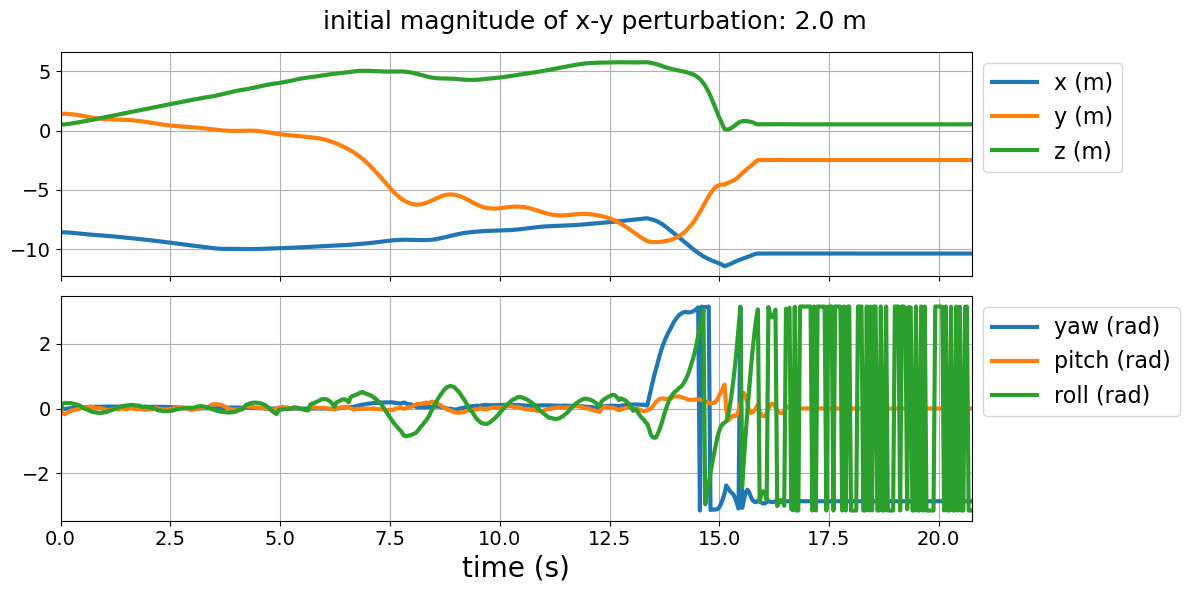

In [162]:
# Create a figure with subplots that all share the same x-axis
fig, ( ax_pos, ax_ori ) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

fig.suptitle('initial magnitude of x-y perturbation: 2.0 m', fontsize = 18)

# # Measurements
# ax_meas.plot(data['t'], data['pos_markers'][:, 0], '.', markersize=4, label=r'$p_{F, x}$')
# ax_meas.plot(data['t'], data['pos_markers'][:, 1], '.', markersize=4, label=r'$p_{F, y}$')
# ax_meas.plot(data['t'], data['pos_markers'][:, 2], '.', markersize=4, label=r'$p_{F, z}$')
# ax_meas.plot(data['t'], data['pos_markers'][:, 3], '.', markersize=4, label=r'$p_{B, x}$')
# ax_meas.plot(data['t'], data['pos_markers'][:, 4], '.', markersize=4, label=r'$p_{B, y}$')
# ax_meas.plot(data['t'], data['pos_markers'][:, 5], '.', markersize=4, label=r'$p_{B, z}$')
# ax_meas.grid()
# ax_meas.legend(fontsize=16, bbox_to_anchor=(1., 1.))
# ax_meas.tick_params(labelsize=14)

# Position
ax_pos.plot(data['t'], data['p_x'], label='x (m)', linewidth=3, color='C0')
ax_pos.plot(data['t'], data['p_y'], label='y (m)', linewidth=3, color='C1')
ax_pos.plot(data['t'], data['p_z'], label='z (m)', linewidth=3, color='C2')
ax_pos.grid()
ax_pos.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_pos.tick_params(labelsize=14)

# Orientation
ax_ori.plot(data['t'], data['yaw'], label='yaw (rad)', linewidth=3)
ax_ori.plot(data['t'], data['pitch'], label='pitch (rad)', linewidth=3)
ax_ori.plot(data['t'], data['roll'], label='roll (rad)', linewidth=3)
ax_ori.grid()
ax_ori.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_ori.tick_params(labelsize=14)

# # Actuator commands
# ax_act.plot(data['t'], data['tau_x'], label='tau_x (N-m)', linewidth=4)
# ax_act.plot(data['t'], data['tau_x_cmd'], '--', label='commanded tau_x (N-m)', linewidth=4)
# ax_act.plot(data['t'], data['tau_y'], label='tau_y (N-m)', linewidth=4)
# ax_act.plot(data['t'], data['tau_y_cmd'], '--', label='commanded tau_y (N-m)', linewidth=4)
# ax_act.plot(data['t'], data['tau_z'], label='tau_z (N-m)', linewidth=4)
# ax_act.plot(data['t'], data['tau_z_cmd'], '--', label='commanded tau_z (N-m)', linewidth=4)
# ax_act.plot(data['t'], data['f_z'] - (0.5 * 9.81), label='f_z - m g (N)', linewidth=4) # <-- FIXME
# ax_act.plot(data['t'], data['f_z_cmd'] - (0.5 * 9.81), '--', label='commanded f_z - m g (N)', linewidth=4) # <-- FIXME
# ax_act.grid()
# ax_act.legend(fontsize=16, bbox_to_anchor=(1., 1.))
# ax_act.tick_params(labelsize=14)

# Set shared x-axis properties
ax_ori.set_xlabel('time (s)', fontsize=20)
ax_ori.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()
plt.show()

In [163]:
fig.savefig('initial_mag_2.0.png', facecolor='white', transparent=False)

### Calculate Equations for rings and trajectory

In [164]:
drone_pos = np.array([data['pos_markers'][:, 0] + data['pos_markers'][:, 3], data['pos_markers'][:, 1] + data['pos_markers'][:, 4], data['pos_markers'][:, 2] + data['pos_markers'][:, 5]]) / 2
ring_poses = np.zeros((44, 3))
ring_norms = np.zeros((44, 3))
ring_rads = np.zeros(44)
for i, ring in enumerate(simulator.rings):
    # p = ring['p']        # <--- position of ring
    # v = ring['R'][:, 0]  # <--- unit vector normal to ring (pointing through it)
    # r = ring['radius']   # <--- radius of ring
    # s = f'ring {i:2d}' + \
    #     f' : p ({p[0]:6.2f}, {p[1]:6.2f}, {p[2]:6.2f})' + \
    #     f' : v ({v[0]:6.2f}, {v[1]:6.2f}, {v[2]:6.2f})' + \
    #     f' : r ({r:6.2f})'
    # print(s)
    ring_poses[i] = ring['p']        # <--- position of ring
    ring_norms[i] = ring['R'][:, 0]  # <--- unit vector normal to ring (pointing through it)
    ring_rads[i] = ring['radius']   # <--- radius of ring

In [165]:
# print(drone_pos)
plane_vectors_1 = np.zeros((44,3))
plane_vectors_2 = np.zeros((44,3))
for i in range(44):
    a = np.array([ring_norms[i][2],0,-ring_norms[i][0]])
    a = a / la.norm(a)
    plane_vectors_1[i] = a
    plane_vectors_2[i] = np.cross(ring_norms[i],a)
    # print(np.dot(plane_vectors_1[i],plane_vectors_2[i]), np.dot(plane_vectors_1[i],ring_poses[i]))

In [166]:
res = 50
circle_coords = np.zeros((44,res,3))
theta = np.linspace(0, 2 * np.pi,50)

#print(circle_coords[0].T[0])
# print(theta)
for i in range(44):
    for j in range(res):
        circle_coords[i][j] = ring_poses[i] + ring_rads[i] * (np.cos(theta[j]) * plane_vectors_1[i] + np.sin(theta[j]) * plane_vectors_2[i])
    

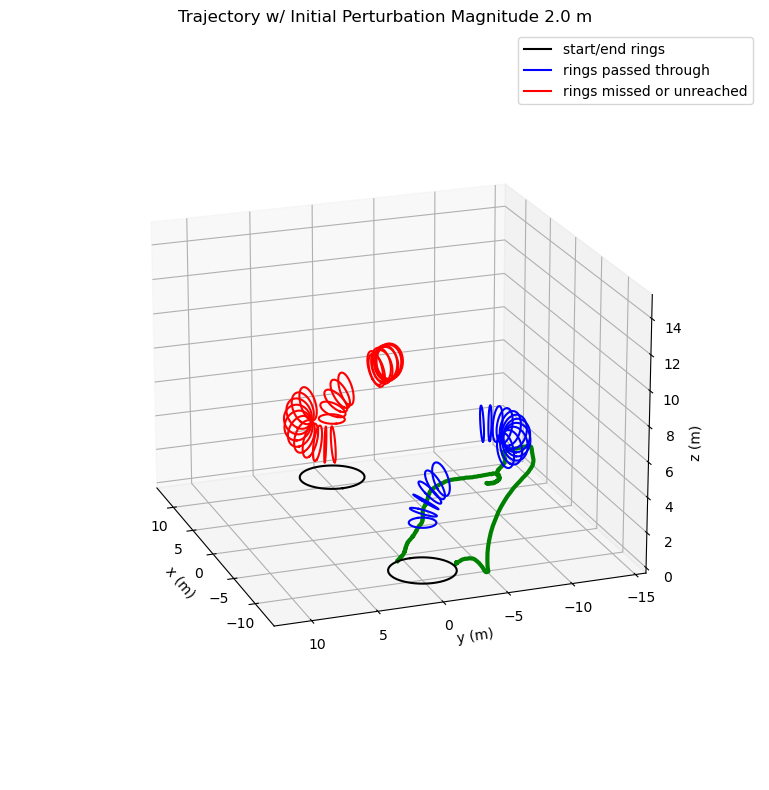

In [167]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(drone_pos[0], drone_pos[1], drone_pos[2], color='g',linewidth=3)
ax.plot(circle_coords[0].T[0], circle_coords[0].T[1], circle_coords[0].T[2], color='k', label='start/end rings')
ax.plot(circle_coords[1].T[0], circle_coords[1].T[1], circle_coords[1].T[2], color='b', label='rings passed through')
for i in range(2,18):
    ax.plot(circle_coords[i].T[0], circle_coords[i].T[1], circle_coords[i].T[2], color='b')
for i in range(18,42):
    ax.plot(circle_coords[i].T[0], circle_coords[i].T[1], circle_coords[i].T[2], color='r')
ax.plot(circle_coords[42].T[0], circle_coords[42].T[1], circle_coords[42].T[2], color='r', label='rings missed or unreached')
ax.plot(circle_coords[43].T[0], circle_coords[43].T[1], circle_coords[43].T[2], color='k')
# ax.plot(0,0,0, marker="o", markersize=1, color='b', label='Earth (not to scale)')
# ax.plot(0,0,0, marker="o", markersize=50, color='b')
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_zlabel("z (m)")
ax.axis('equal')
ax.set_zlim(0, 15)
ax.set_box_aspect(aspect=None,zoom=0.8)
ax.view_init(elev=20, azim=160)
plt.title('Trajectory w/ Initial Perturbation Magnitude 2.0 m')
plt.legend()
plt.tight_layout()
plt.show()

In [170]:
fig.savefig('traj_initial_mag_2.0.png', facecolor='white', transparent=False)